# TP6 :


In [34]:
import numpy as np
import torch
import torchvision

from torchvision import datasets, transforms
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# PCA on CIFAR

We plot the results of PCA on CIFAR-10 and MNIST datasets.

In [35]:
def fit_pca_and_reconstruct(X, k, channels, side):
    pca = PCA(n_components=k)
    X_pca = pca.fit_transform(X)
    X_rec = pca.inverse_transform(X_pca)
    X_rec = torch.tensor(X_rec).view(-1, channels, side, side)
    X_rem = torch.tensor(X).view(-1, channels, side, side) - X_rec
    return X_rec, X_rem, pca


# Show originals vs reconstructions
def show_pair(orig, rec, rem, n=5):
    plt.figure(figsize=(2 * n, 4))
    for i in range(n):
        plt.subplot(3, n, i + 1)
        plt.imshow(orig[i].permute(1, 2, 0))
        plt.axis("off")
        plt.subplot(3, n, n + i + 1)
        plt.imshow(rec[i].permute(1, 2, 0).clamp(0, 1))
        plt.axis("off")
        plt.subplot(3, n, 2 * n + i + 1)
        plt.imshow(rem[i].permute(1, 2, 0).clamp(0, 1))
        plt.axis("off")
    plt.show()

Files already downloaded and verified


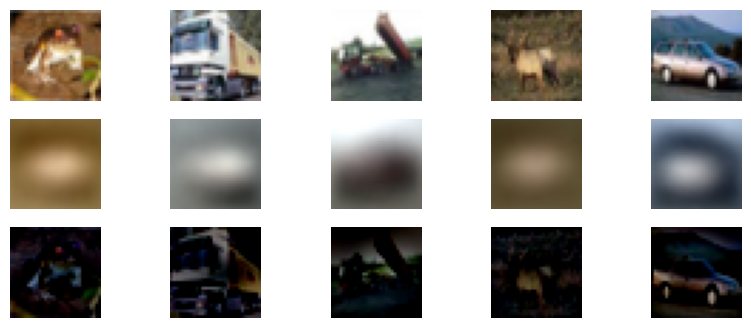

In [36]:
# Load CIFAR-10
transform = transforms.Compose([transforms.ToTensor()])
dataset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)
images = torch.stack(
    [x for x, _ in torch.utils.data.Subset(dataset, range(10000))]
)  # 10k images
X = images.view(len(images), -1).numpy()  # flatten to (N, 3072)
channels = 3
side = 32

# Fit PCA
k = 10
X_rec, X_rem, pca = fit_pca_and_reconstruct(X, k, channels, side)
show_pair(images, X_rec, X_rem)

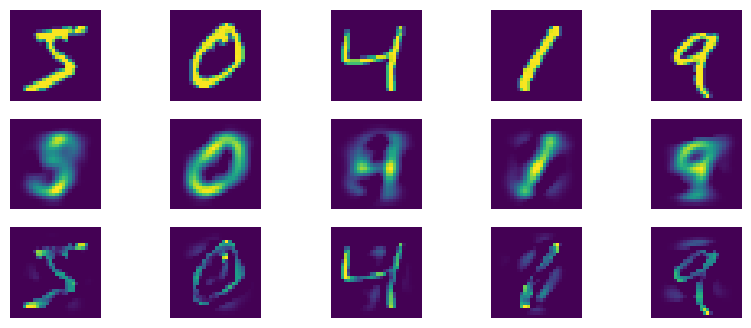

In [37]:
transform = transforms.Compose([transforms.ToTensor()])
dataset = torchvision.datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
images = torch.stack(
    [x for x, _ in torch.utils.data.Subset(dataset, range(10000))]
)  # 10k images
X = images.view(len(images), -1).numpy()
channels = 1
side = 28


# Fit PCA
k = 10
X_rec, X_rem, pca = fit_pca_and_reconstruct(X, k, channels, side)
show_pair(images, X_rec, X_rem)

# Simple Autoencoder

Build a simple autoencoder and train it on MNIST.


In [38]:
class AutoEncoder(nn.Module):
    def __init__(self, d_in=28**2, d_latent=2):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(d_in, 16),
            # nn.ReLU(),
            # nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, d_latent),
        )
        self.decoder = nn.Sequential(
            nn.Linear(d_latent, 16),
            # nn.ReLU(),
            # nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(16, d_in),
            nn.Sigmoid(),  # outputs in [0,1]
        )

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        # x : (B, 1, 28, 28)
        # need to flatten to give as input to the encoder
        # return both reconstructed x and latent z

        z = self.encode(x.view(-1, 28 * 28))
        x_hat = self.decode(z)
        return x_hat, z


model = AutoEncoder(d_in=28**2, d_latent=2).to(device)

# Loss & optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

transform = transforms.ToTensor()
train_loader = DataLoader(
    datasets.MNIST(".", train=True, download=True, transform=transform),
    batch_size=128,
    shuffle=True,
)

epochs = 50
for epoch in range(epochs):
    epoch_loss = 0.0
    for xb, _ in train_loader:
        optimizer.zero_grad()
        x_hat, _ = model(xb)
        x_hat = x_hat.reshape(-1, 1, 28, 28)
        loss = criterion(x_hat, xb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * xb.size(0)

    if (epoch + 1) % 10 == 0:
        print(
            f"Epoch {epoch + 1:02d}/{epochs} | MSE: {epoch_loss / len(train_loader):.5f}"
        )


Epoch 10/50 | MSE: 6.73537
Epoch 20/50 | MSE: 6.35151


KeyboardInterrupt: 

In [ ]:
test_loader = DataLoader(
    datasets.MNIST(".", train=False, download=True, transform=transform),
    batch_size=32,
    shuffle=True,
)

X_test, y_test = list(test_loader)[0]

# ----- Reconstruct a small test batch -----
with torch.no_grad():
    x_hat_test, z_test = model(X_test)

# Pick 10 examples to display
n_show = 10
idx = np.arange(len(X_test))
np.random.shuffle(idx)
idx = idx[:n_show]

orig = X_test[idx].numpy().reshape(n_show, 28, 28)
reco = x_hat_test[idx].numpy().reshape(n_show, 28, 28)

# Grid of originals
fig, axes = plt.subplots(2, n_show, figsize=(n_show * 1.1, 2.4))
for i in range(n_show):
    axes[0, i].imshow(orig[i], cmap="gray_r")
    axes[0, i].axis("off")
    axes[1, i].imshow(reco[i], cmap="gray_r")
    axes[1, i].axis("off")
axes[0, 0].set_title("Originals")
axes[1, 0].set_title("Reconstructions")
plt.tight_layout()
plt.show()

# 2D latent space scatter colored by class
Z = z_test.numpy()
Y = y_test.numpy()

plt.figure(figsize=(5.5, 5.0))
for d in range(10):
    mask = Y == d
    plt.scatter(Z[mask, 0], Z[mask, 1], s=12, label=str(d), alpha=0.8)
plt.xlabel("z1")
plt.ylabel("z2")
plt.title("2D Latent Space (test data)")
plt.legend(markerscale=1.2, fontsize=8, ncol=2, frameon=True)
plt.tight_layout()

# Decode some random points in the latent space

In [ ]:
grid_size = 4
with torch.no_grad():
    z = 10 * torch.randn(grid_size**2, 2).to(device) + torch.tensor([5, 5])
    samples = model.decode(z).cpu().view(-1, 1, 28, 28)

grid = torch.cat(
    [
        torch.cat(list(samples[i * grid_size : (i + 1) * grid_size]), dim=2)
        for i in range(grid_size)
    ],
    dim=1,
)
plt.imshow(grid.squeeze(), cmap="gray")
plt.axis("off")
plt.show()

# Variational AutoEncoder

In [ ]:
class VAE(nn.Module):
    def __init__(self, latent_dim=2):
        super().__init__()
        self.enc1 = nn.Linear(28 * 28, 400)
        self.enc_mu = nn.Linear(400, latent_dim)
        self.enc_logvar = nn.Linear(400, latent_dim)

        self.dec = nn.Sequential(
            nn.Linear(latent_dim, 400),
            nn.ReLU(),
            nn.Linear(400, 28 * 28),
            nn.Sigmoid(),
        )

    def encode(self, x):
        h = F.relu(self.enc1(x))
        return self.enc_mu(h), self.enc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.dec(z)

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 28 * 28))
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar


def KL(mu, logvar):
    # KL divergence between N(mu, var) and N(0,1)
    return 0.5 * torch.sum(mu**2 + logvar.exp() - logvar - 1)


def vae_loss(x, x_hat, mu, logvar):
    BCE = F.binary_cross_entropy(x_hat, x.view(-1, 28 * 28), reduction="sum")
    KLD = KL(mu, logvar)
    return BCE + KLD


In [ ]:
latent_dim = 2

device = "cuda" if torch.cuda.is_available() else "cpu"
vae = VAE(latent_dim=latent_dim).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

transform = transforms.ToTensor()
train_loader = DataLoader(
    datasets.MNIST(".", train=True, download=True, transform=transform),
    batch_size=128,
    shuffle=True,
)

for epoch in range(20):
    vae.train()
    total_loss = 0
    for x, _ in train_loader:
        x = x.to(device)
        optimizer.zero_grad()
        x_hat, mu, logvar = vae(x)
        loss = vae_loss(x, x_hat, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader.dataset):.4f}")

# Sampling and visualization

In [ ]:
grid_size = 6
with torch.no_grad():
    z = torch.ones(grid_size**2, latent_dim).to(device)
    samples = vae.decode(z).cpu().view(-1, 1, 28, 28)

grid = torch.cat(
    [
        torch.cat(list(samples[i * grid_size : (i + 1) * grid_size]), dim=2)
        for i in range(grid_size)
    ],
    dim=1,
)
plt.imshow(grid.squeeze(), cmap="gray")
plt.axis("off")
plt.show()

In [ ]:
n_show = 10
test_loader = DataLoader(
    datasets.MNIST(".", train=False, download=True, transform=transform),
    batch_size=n_show,
    shuffle=True,
)

with torch.no_grad():
    x, _ = list(test_loader)[10]
    x_hat, _, _ = vae(x)
    x, x_hat = x.cpu(), x_hat.cpu()

orig = x[:n_show]
recon = x[:n_show]

fig, axes = plt.subplots(2, n_show, figsize=(n_show * 1.2, 2.6))
for i in range(n_show):
    axes[0, i].imshow(orig[i].squeeze(), cmap="gray_r")
    axes[0, i].axis("off")
    axes[1, i].imshow(recon[i].squeeze(), cmap="gray_r")
    axes[1, i].axis("off")
axes[0, 0].set_title("Originals")
axes[1, 0].set_title("Reconstructions")
plt.tight_layout()
plt.show()

In [ ]:
# @dataclass
# class MAEConfig:
#     img_size: int = 224
#     patch_size: int = 16
#     in_chans: int = 3
#     embed_dim: int = 512
#     depth: int = 8
#     num_heads: int = 8
#     mask_ratio: float = 0.75
#     decoder_dim: int = 256
#     decoder_depth: int = 4
#     decoder_heads: int = 8


# class PatchEmbed(nn.Module):
#     def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
#         super().__init__()
#         self.proj = nn.Conv2d(
#             in_chans, embed_dim, kernel_size=patch_size, stride=patch_size
#         )

#     def forward(self, x):
#         x = self.proj(x)  # (B, D, H/P, W/P)
#         x = x.flatten(2).transpose(1, 2)  # (B, N, D)
#         return x


# class TransformerEncoder(nn.Module):
#     def __init__(self, dim, depth, num_heads):
#         super().__init__()
#         layer = nn.TransformerEncoderLayer(
#             d_model=dim,
#             nhead=num_heads,
#             dim_feedforward=dim * 4,
#             activation="gelu",
#             batch_first=True,
#             norm_first=True,
#         )
#         self.encoder = nn.TransformerEncoder(layer, num_layers=depth)

#     def forward(self, x):
#         return self.encoder(x)


# class TransformerDecoder(nn.Module):
#     def __init__(self, dim, depth, num_heads):
#         super().__init__()
#         layer = nn.TransformerEncoderLayer(
#             d_model=dim,
#             nhead=num_heads,
#             dim_feedforward=dim * 4,
#             activation="gelu",
#             batch_first=True,
#             norm_first=True,
#         )
#         self.decoder = nn.TransformerEncoder(layer, num_layers=depth)

#     def forward(self, x):
#         return self.decoder(x)


# class MaskedAutoencoderViT(nn.Module):
#     def __init__(self, cfg: MAEConfig):
#         super().__init__()
#         self.cfg = cfg
#         self.patch_embed = PatchEmbed(
#             cfg.img_size, cfg.patch_size, cfg.in_chans, cfg.embed_dim
#         )
#         self.num_patches = (cfg.img_size // cfg.patch_size) ** 2

#         self.cls_token = nn.Parameter(torch.zeros(1, 1, cfg.embed_dim))
#         self.pos_embed = nn.Parameter(
#             torch.zeros(1, self.num_patches + 1, cfg.embed_dim)
#         )

#         self.encoder = TransformerEncoder(cfg.embed_dim, cfg.depth, cfg.num_heads)
#         # print("Loss:", loss.item())

#         self.mask_token = nn.Parameter(torch.zeros(1, 1, cfg.decoder_dim))
#         self.decoder_embed = nn.Linear(cfg.embed_dim, cfg.decoder_dim)
#         self.decoder_pos_embed = nn.Parameter(
#             torch.zeros(1, self.num_patches + 1, cfg.decoder_dim)
#         )
#         self.decoder = TransformerDecoder(
#             cfg.decoder_dim, cfg.decoder_depth, cfg.decoder_heads
#         )
#         self.head = nn.Linear(cfg.decoder_dim, cfg.patch_size**2 * cfg.in_chans)

#         nn.init.trunc_normal_(self.pos_embed, std=0.02)
#         nn.init.trunc_normal_(self.decoder_pos_embed, std=0.02)

#     @torch.no_grad()
#     def random_masking(self, x, mask_ratio):
#         B, N, D = x.shape
#         len_keep = int(N * (1 - mask_ratio))
#         noise = torch.rand(B, N, device=x.device)
#         ids_shuffle = torch.argsort(noise, dim=1)
#         ids_restore = torch.argsort(ids_shuffle, dim=1)
#         ids_keep = ids_shuffle[:, :len_keep]
#         x_masked = torch.gather(x, 1, ids_keep.unsqueeze(-1).repeat(1, 1, D))
#         mask = torch.ones(B, N, device=x.device)
#         mask[:, :len_keep] = 0
#         mask = torch.gather(mask, 1, ids_restore)
#         return x_masked, mask, ids_restore

#     def forward(self, imgs):
#         x = self.patch_embed(imgs)
#         B, N, D = x.shape
#         cls_token = self.cls_token.expand(B, -1, -1)
#         x = torch.cat([cls_token, x], dim=1)
#         x = x + self.pos_embed[:, : N + 1]

#         x_cls, x_patches = x[:, :1, :], x[:, 1:, :]
#         x_masked, mask, ids_restore = self.random_masking(
#             x_patches, self.cfg.mask_ratio
#         )
#         x = torch.cat([x_cls, x_masked], dim=1)

#         x = self.encoder(x)
#         latent = x[:, 0]

#         # Decode
#         x = self.decoder_embed(x)
#         x_cls, x_patches = x[:, :1, :], x[:, 1:, :]
#         B = x.shape[0]
#         mask_tokens = self.mask_token.repeat(
#             B, self.num_patches - x_patches.shape[1], 1
#         )
#         x_full = torch.cat([x_patches, mask_tokens], dim=1)
#         x_full = torch.gather(
#             x_full, 1, ids_restore.unsqueeze(-1).repeat(1, 1, x_full.shape[-1])
#         )
#         x_full = torch.cat([x_cls, x_full], dim=1)
#         x_full = x_full + self.decoder_pos_embed[:, : self.num_patches + 1]
#         x_full = self.decoder(x_full)
#         pred = self.head(x_full[:, 1:, :])

#         # Compute loss
#         p = self.cfg.patch_size
#         with torch.no_grad():
#             target = F.unfold(imgs, kernel_size=p, stride=p).transpose(1, 2)
#             loss = (pred - target) ** 2
#             loss = (loss.mean(-1) * mask).sum() / mask.sum()
#             return loss, pred, mask

#     @torch.no_grad()
#     def encode(self, imgs):
#         x = self.patch_embed(imgs)
#         B, N, D = x.shape
#         cls_token = self.cls_token.expand(B, -1, -1)
#         x = torch.cat([cls_token, x], dim=1)
#         x = x + self.pos_embed[:, : N + 1]
#         x = self.encoder(x)
#         return x[:, 0]


# cfg = MAEConfig(img_size=128, patch_size=16)
# model = MaskedAutoencoderViT(cfg)
# imgs = torch.randn(4, 3, cfg.img_size, cfg.img_size)
# loss, _, _ = model(imgs)
# print("Loss:", loss.item())